In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, RandomizedSearchCV, train_test_split
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.neural_network import MLPRegressor

df = pd.read_csv('data.csv')

X = df.drop('overall_rating', axis=1)
y = df['overall_rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    return mse, mae, r2

def print_metrics(mse, mae, r2):
    print(f'MSE: {mse:.3f}')
    print(f'MAE: {mae:.3f}')
    print(f'R2: {r2:.3f}')

In [8]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold

def cv_evaluate(model, X, y):
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    scoring = {
        'r2': make_scorer(r2_score),
        'mae': make_scorer(mean_absolute_error),
        'mse': make_scorer(mean_squared_error)
    }
    cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=False)

    for key in cv_results.keys():
        if key in ['fit_time', 'score_time']:
            continue
        print(f"{key}: {cv_results[key]}")
        print(f"{key} trung bình: {cv_results[key].mean():.3f} ± {cv_results[key].std():.3f}")
        print()

In [4]:
base_learners = [
    ('svr', SVR(C=10, gamma='auto', kernel='rbf')),
    ('dt', DecisionTreeRegressor(random_state=42)),
    ('knn', KNeighborsRegressor()),
    ('rf', RandomForestRegressor(random_state=42)),
    ('ada', AdaBoostRegressor(random_state=42)),
    ('gb', GradientBoostingRegressor(random_state=42)),
    ('xgb', XGBRegressor(random_state=42)),
    ('mlp', MLPRegressor(random_state=42, max_iter=500))
]

In [5]:
meta_learner = LinearRegression()

stack = StackingRegressor(
    estimators=base_learners, 
    final_estimator=meta_learner
)

In [6]:
pipeline = Pipeline([
    ('te', TargetEncoder(cols=['nationality'])),
    ('scaler', StandardScaler()),
    ('stack', stack)
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('te', TargetEncoder(cols=['nationality'])),
                ('scaler', StandardScaler()),
                ('stack',
                 StackingRegressor(estimators=[('svr', SVR(C=10, gamma='auto')),
                                               ('dt',
                                                DecisionTreeRegressor(random_state=42)),
                                               ('knn', KNeighborsRegressor()),
                                               ('rf',
                                                RandomForestRegressor(random_state=42)),
                                               ('ada',
                                                AdaBoostRegressor(random_state=42)),
                                               ('gb',
                                                GradientBoostingRegres...
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=None,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=42, ...)),
                                               ('mlp',
                                                MLPRegressor(max_iter=500,
                                                             random_state=42))],
                                   final_estimator=LinearRegression()))])

In [10]:
print("======== Stacking Method ========")

print("Hold Out evaluation:")

print("Training Set:")
print_metrics(*evaluate_model(pipeline, X_train, y_train))

print("\nTesting Set:")
print_metrics(*evaluate_model(pipeline, X_test, y_test))

======== Stacking Method ========
Hold Out evaluation:
Training Set:
MSE: 1.556
MAE: 0.624
R2: 0.968

Testing Set:
MSE: 2.753
MAE: 0.943
R2: 0.944


In [19]:
y_pred = pipeline.predict(X_test)

predictions_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

In [24]:
sorted_predictions_df = predictions_df.reset_index(drop=True)
print(sorted_predictions_df.head(20))

    Actual  Predicted
0       60  60.755334
1       55  58.169013
2       64  63.814848
3       70  70.483038
4       52  52.171430
5       71  72.170271
6       70  70.528911
7       70  69.481670
8       67  72.451229
9       70  68.811282
10      69  70.610401
11      67  64.567927
12      68  68.959336
13      66  65.717109
14      71  70.737234
15      72  73.210400
16      51  55.589853
17      70  70.052628
18      73  73.023253
19      74  73.541892


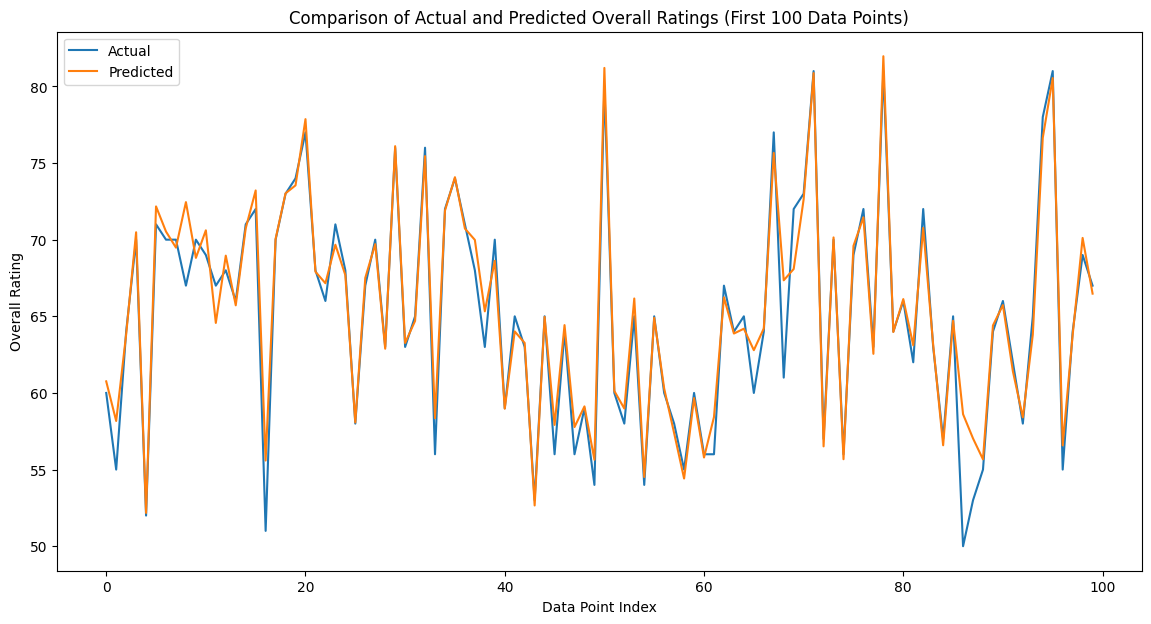

In [23]:
plt.figure(figsize=(14, 7))
plt.plot(sorted_predictions_df['Actual'][:100].values, label='Actual')
plt.plot(sorted_predictions_df['Predicted'][:100].values, label='Predicted')
plt.xlabel('Data Point Index')
plt.ylabel('Overall Rating')
plt.title('Comparison of Actual and Predicted Overall Ratings (First 100 Data Points)')
plt.legend()
plt.show()

In [25]:
stack = pipeline.named_steps['stack']

In [26]:
import joblib

joblib.dump(stack, 'stack_model.pkl')
print("Mô hình Stacking đã được lưu thành công dưới tên 'stack_model.pkl'")

Mô hình Stacking đã được lưu thành công dưới tên 'stack_model.pkl'
